In [1]:

# conda create --name torch_env python=3.9
# conda activate torch_env

# conda install -c anaconda ipykernel
# python -m ipykernel install --user --name=torch_env

# conda install -c "nvidia/label/cuda-11.6.0" cuda-toolkit
# pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116

# python -c "import torch; print(torch.version.cuda)"

# pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-geometric
# pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.12.1+cu116.html
# pip install torch-cluster -f https://data.pyg.org/whl/torch-1.12.1+cu116.html

# pip install pyyaml tomli matplotlib sympy ipywidgets scikit-image


In [2]:
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# WCSPH TODO:
1. Add kinematic visocisty
2. Backport velocity diffusion to DFSPH code (own module)
3. Add tensile correction from pysph https://github.com/pypr/pysph/blob/bc5c793a82cb4a1f57a7602aea1be85d5e4cc87f/pysph/sph/wc/basic.py#L129
4. Add delta+ sph shifting
5. Add delta+ pressure switch
6. Add RK4/pec integration
7. IMPROVE PERFORMANCE

# Current TODO:
1. ~~Add boundary sampling with particles~~
2. ~~Add offset boundary sampling~~
3. ~~Add akinci-like boundary treatment~~
4. ~~Add mirror pressure term to akinci boundary~~
5. ~~Add MLS pressure term to akinci boundary~~
6. ~~Add body forces to akinci boundary~~
7. Add drag forces to akinci boundary
6. ~~Add Pressure Boundaries approach (maybe)~~
6. ~~Add dense boundary sampling~~
6. ~~Add ghost particle based MLS pressure term in prep for delta sph~~
7. ~~delta sph with fixed ghost particles~~
8. delta+ sph
9. Add RK4 somehow?!
10. delta sph with boundary integrals?!


# TODO:

1. ~~spherical emission~~
2. ~~adaptive timestepping~~
3. ~~divergence solver~~
4. ~~xsph viscosity~~
5. monaghan viscosity
6. ~~setup dambreak~~
7. setup dambreak with obstacle
8. setup flow past cylinder
9. add wcsph (müller)
10. add compressible sph
11. setup shockwave scenario for compressible sph
12. ~~density solver warm start~~
13. ~~particle shifting~~
14. shifting needs thresholding for free surfaces!! (delta+ sph paper shifting idea based on renormalization vector??)
15. ~~velocityBC~~
16. device integrals for sdf based renormalization matrix
17. ~~rewrite MLS interpolation for stability based on delta+ sph~~
18. ~~improve MLS performance~~
19. ~~improve overall performance~~

In [4]:
from src.simulationBase import SPHSimulation
from src.kernels import kernel, kernelGradient, spikyGrad, wendland, wendlandGrad, cohesionKernel, getKernelFunctions
from src.util import *
from src.module import Module
from src.parameter import Parameter

In [5]:
# import modules to build simulation with
from src.modules.density import densityModule
from src.modules.neighborSearch import neighborSearchModule
from src.modules.akinciTension import akinciTensionModule
from src.modules.sdfBoundary import sdfBoundaryModule, sdPolyDerAndIntegral
from src.modules.akinciBoundary import akinciBoundaryModule
from src.modules.solidBoundary import solidBoundaryModule
from src.modules.periodicBC import periodicBCModule
from src.modules.velocityBC import velocityBCModule
from src.modules.implicitShifting import implicitIterativeShiftModule
from src.modules.gravity import gravityModule
from src.modules.xsph import xsphModule
from src.modules.dfsph import dfsphModule
from src.modules.deltaSPH import *
from src.modules.diffusion import diffusionModule
from src.modules.densityDiffusion import densityDiffusionModule
from src.modules.adaptiveDT import adaptiveTimeSteppingModule

from src.modules.momentum import momentumModule
from src.modules.pressure import pressureModule
from src.modules.laminar import laminarViscosityModule

In [6]:
# fig, axis = plt.subplots(2,2, figsize=(9 *  1.09, 9), squeeze = False)
# for axx in axis:
#     for ax in axx:
#         ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
#         ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
#         ax.axis('equal')
#         ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
#         ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

# positions = state['fluidPosition'].detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# data = polyDer[:,0].detach().cpu().numpy()


# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = polyGrad[:,0].detach().cpu().numpy(), s = 4)
# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

In [7]:
# from src.dfsph import dfsphSimulation

In [8]:
tomlConfig = """
[timestep]
fixed = true
max = 0.0004
min = 0.0004

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-3
divergenceThreshold = 1e-2
divergenceSolver = false
backgroundPressure = false
relaxedJacobiOmega = 0.5

[domain]
min = [-2, -2]
max = [2, 2]
adjustParticle = true
adjustDomain = true

[periodicBCs]
periodicX = true
periodicY = true

[velocitySources]
[velocitySources.one]
min = [1,-2]
max = [2,2]
velocity = [0,1]

[emitter2.fluidR]
fillDomain = false
min = [0.05,-0.25]
max = [0.5,0.25]
velocity = [ -2.0, 0.0]
adjust = false
shape = 'sphere'

[emitter2.fluidL]
fillDomain = false
min = [-1.0,-0.5]
max = [-0.0,0.5]
velocity = [ 0.0, 0.0]
adjust = false

[emitter2.fluid]
fillDomain = false
min = [-0.25,-1.99]
max = [0.25,-1.49]
velocity = [ 0.0, 0.0]
adjust = false
shape = 'sphere'

[emitter2.fluidBulk]
fillDomain = false
min = [-2,-2]
max = [-1.5, -1.5]
velocity = [ 0.0, 0.0]
adjust = true

[emitter.damBreak]
fillDomain = false
min = [-2,-2]
max = [-1.0, -1.0]
velocity = [ 0.0, 0.0]
adjust = true

[compute]
device='cpu'

[particle]
radius = 0.01

[gravity2]
magnitude = 0

[fluid]
c = 24.261

[simulation]
boundaryScheme = 'solid'
verbose = false

[pressure]
fluidPressureTerm = 'TaitEOS'
boundaryPressureTerm = 'PBSPH'
pressureTerm1 = 'PBSPH'
pressureTerm5 = 'TaitEOS'
pressureTerm4 = 'ghostMLS'
pressureTerm2 = 'deltaMLS'
pressureTerm3 = 'MLSPressure'
kappa = 1.5
gamma = 7.0


[diffusion]
velocityScheme = 'deltaSPH'
alpha = 0.01
boundaryDiffusion = false

[integration]
scheme = 'explicitEuler'
dt = 0.00005

[shifting]
enabled = false
scheme = 'deltaPlus'

[deltaSPH]
HughesGrahamCorrection = true
delta = 0.1

[kernel]
targetNeighbors = 50

[akinciBoundary]
beta = 0.125
gamma = 0.7
""" 


In [9]:
# debugPrint(sphSimulation.config['deltaSPH']['c0'])

In [10]:

class deltaSPHSimulation(SPHSimulation):    
    def __init__(self, config = tomli.loads('')):
        super().__init__(config)
        
        self.modules = []
        self.moduleParameters = []
        
        if self.verbose: print('Processing modules')
        self.neighborSearch = neighborSearchModule()
        self.sphDensity = densityModule()
        self.periodicBC = periodicBCModule()
        self.deltaSPH = deltaSPHModule()
        self.velocityBC = velocityBCModule()
#         self.shiftModule = implicitIterativeShiftModule()
        self.gravityModule = gravityModule()
        self.adaptiveDT = adaptiveTimeSteppingModule()
        self.surfaceTension = akinciTensionModule()
        
        self.modules.append(self.neighborSearch)
        self.modules.append(self.sphDensity)
        self.modules.append(self.periodicBC)
        self.modules.append(self.velocityBC)
        self.modules.append(self.deltaSPH)
        
        self.momentumModule = momentumModule()
        self.modules.append(self.momentumModule)
        self.pressureModule = pressureModule()
        self.modules.append(self.pressureModule)
        
        if self.config['diffusion']['velocityScheme'] == 'xsph':
            self.velocityDiffusionModule = xsphModule()
            self.modules.append(self.velocityDiffusionModule)
            
        if self.config['diffusion']['velocityScheme'] == 'deltaSPH':
            self.velocityDiffusionModule = diffusionModule()
            self.modules.append(self.velocityDiffusionModule)
            
        self.densityDiffusionModule = densityDiffusionModule()
        self.modules.append(self.densityDiffusionModule)
        
        self.densityDiffusionModule = densityDiffusionModule()
        self.modules.append(self.densityDiffusionModule)
        self.laminarViscosityModule = laminarViscosityModule()
        self.modules.append(self.laminarViscosityModule)
        
        
#         self.modules.append(self.shiftModule)
        self.modules.append(self.gravityModule)
        self.modules.append(self.adaptiveDT)
        self.modules.append(self.surfaceTension)    
        if self.config['simulation']['boundaryScheme'] == 'solid': 
            self.boundaryModule = solidBoundaryModule() 
            self.modules.append(self.boundaryModule)  
        if self.config['simulation']['boundaryScheme'] == 'SDF': 
            self.boundaryModule = sdfBoundaryModule() 
            self.modules.append(self.boundaryModule)  
        if self.config['simulation']['boundaryScheme'] == 'Akinci': 
            self.boundaryModule = akinciBoundaryModule() 
            self.modules.append(self.boundaryModule)  
        
        if self.verbose: print('Processing module parameters')
        for module in self.modules:    
            moduleParams =  module.getParameters()
            if moduleParams is not None:
                for param in moduleParams:
                    param.parseConfig(self.config)
                self.moduleParameters = self.moduleParameters + moduleParams
                
    def initializeSimulation(self):
        super().initializeSimulation()
        
        
    def timestep(self):
        step = ' 1 - Enforcing periodic boundary conditions'
        if self.verbose: print(step)
        with record_function(step):
            self.periodicBC.enforcePeriodicBC(self.simulationState, self)
            
        step = ' 2 - Fluid neighborhood search'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidNeighbors'], self.simulationState['fluidDistances'], self.simulationState['fluidRadialDistances'] = self.neighborSearch.search(self.simulationState, self)
            
        step = ' 3 - Boundary neighborhood search'
        if self.verbose: print(step)
        with record_function(step):
            self.boundaryModule.boundaryFilterNeighborhoods(self.simulationState, self)
            self.boundaryModule.boundaryNeighborhoodSearch(self.simulationState, self)

#         step = ' 4 - Fluid - Fluid density evaluation'
#         if self.verbose: print(step)
#         with record_function(step):
#             self.simulationState['fluidDensity'] = self.sphDensity.evaluate(self.simulationState, self)    
#             self.periodicBC.syncQuantity(self.simulationState['fluidDensity'], self.simulationState, self)
        
#         step = ' 5 - Fluid - Boundary density evaluation'
#         if self.verbose: print(step)
#         with record_function(step):
#             self.simulationState['fluidDensity'] += self.boundaryModule.evalBoundaryDensity(self.simulationState, self)        
#             self.periodicBC.syncQuantity(self.simulationState['fluidDensity'], self.simulationState, self)
            
#         if self.config[]
        step = '4 - density  evaluation'
        if self.verbose: print(step)
        with record_function(step):             
            self.simulationState['fluidVolume'] = self.simulationState['fluidArea'] / self.simulationState['fluidDensity']
            self.boundaryModule.computeBoundaryDensitymDBC(self.simulationState, self)
            self.boundaryModule.fluidVolume = self.boundaryModule.boundaryVolume / self.boundaryModule.boundaryDensity

        step = ' 6 - Initializing acceleration'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidAcceleration'][:] = 0. 
            
        step = ' 7 - External force evaluation'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['fluidAcceleration'] += self.gravityModule.evaluate(self.simulationState, self)
            self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
        
#         step = ' 9 - Surface tension force evaluation'
#         if self.verbose: print(step)
#         with record_function(step):
#             self.simulationState['fluidNormals'] = self.surfaceTension.computeNormals(self.simulationState, self)
#             self.periodicBC.syncQuantity(self.simulationState['fluidNormals'], self.simulationState, self)
#             self.simulationState['fluidCohesionForce'] = self.surfaceTension.cohesionForce(self.simulationState, self)
#             self.simulationState['fluidCurvatureForce'] = self.surfaceTension.curvatureForce(self.simulationState, self)
#             self.simulationState['fluidAcceleration'] += self.simulationState['fluidCurvatureForce']
#             self.simulationState['fluidAcceleration'] += self.simulationState['fluidCohesionForce']
#             self.periodicBC.syncQuantity(self.simulationState['fluidAcceleration'], self.simulationState, self)
            
        
#         step = '11 - Velocity update step'
#         if self.verbose: print(step)
#         with record_function(step):
#             self.simulationState['fluidVelocity'] += self.simulationState['dt'] * self.simulationState['fluidAcceleration']
#             self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
#         step = '12 - XSPH diffusion evaluation'
#         if self.verbose: print(step)
#         with record_function(step):
#             self.simulationState['fluidAcceleration'] += self.diffusionModule.evaluate(self.simulationState, self)
#             self.periodicBC.syncQuantity(xsphFluidCorrection, self.simulationState, self)
            
#             self.simulationState['fluidVelocity'] += self.simulationState['dt'] + diffusion
#         debugPrint(xsphFluidCorrection)
        
#         step = ' 1 - Boundary friction evaluation'
#         if self.verbose: print(step)
#         with record_function(step):
#         self.boundaryModule.evalBoundaryFriction(self.simulationState, self)
#         xsphBoundaryCorrection = self.XSPH.boundaryTerm(self.simulationState, self)
#         self.periodicBC.syncQuantity(xsphBoundaryCorrection, self.simulationState, self)
#         self.simulationState['fluidVelocity'] += xsphBoundaryCorrection
        
#         step = '13 - Velocity source contribution'
#         if self.verbose: print(step)
#         with record_function(step):
#             self.velocityBC.enforce(self.simulationState, self)
#             self.periodicBC.syncQuantity(self.simulationState['fluidVelocity'], self.simulationState, self)
        
#         step = '14 - Position update step'
#         if self.verbose: print(step)
#         with record_function(step):
#             self.simulationState['fluidPosition'] += self.simulationState['fluidVelocity'] * self.simulationState['dt']
            
#         step = ' 1 - Shifting positions'
#         if self.verbose: print(step)
#         with record_function(step):
#         self.shiftModule.applyShifting(sphSimulation.simulationState, sphSimulation)
#         self.periodicBC.syncQuantity(self.simulationState['fluidUpdate'], self.simulationState, self)
#         self.simulationState['fluidPosition'] += self.simulationState['fluidUpdate']
        
        step = ' 8 - momentum equation'
        if self.verbose: print(step)
        with record_function(step):     
            self.momentumModule.computeDpDt(self.simulationState, self)
            
        step = ' 9 - density diffusion'
        if self.verbose: print(step)
        with record_function(step):     
            self.momentumModule.dpdt += self.densityDiffusionModule.computeDensityDiffusion(self.simulationState, self)
            
        step = '10 - pressure evaluation'
        if self.verbose: print(step)
        with record_function(step):     
            self.pressureModule.computePressure(self.simulationState, self)
            self.pressureModule.computePressureAcceleration(self.simulationState, self)
            
        step = '11 - velocity diffusion'
        if self.verbose: print(step)
        with record_function(step):     
            self.velocityDiffusionModule.evaluate(self.simulationState, self)
    
        step = '12 - laminar viscosity'
        if self.verbose: print(step)
        with record_function(step):       
            self.laminarViscosityModule.computeLaminarViscosity(self.simulationState, self)
            
        step = '13 - Integration'
        if self.verbose: print(step)
        with record_function(step):
            
            self.simulationState['fluidAcceleration'] += self.pressureModule.pressureAccel + self.velocityDiffusionModule.velocityDiffusion + self.laminarViscosityModule.laminarViscosity
            self.simulationState['fluidVelocity'] += self.simulationState['dt'] * self.simulationState['fluidAcceleration']
            self.simulationState['fluidPosition'] += self.simulationState['dt'] * self.simulationState['fluidVelocity']
            self.simulationState['fluidDensity'] += self.simulationState['dt'] * self.momentumModule.dpdt / self.config['fluid']['restDensity']
            
#             self.boundaryModule.boundaryDensity = 1 + scatter(self.boundaryModule.pgPartial * (self.simulationState['fluidDensity'][self.boundaryModule.ghostToFluidNeighbors[1]] - 1), self.boundaryModule.ghostToFluidNeighbors[0], dim=0, dim_size = self.boundaryModule.numPtcls, reduce='add')

            
#             self.boundaryModule.boundaryDensity += self.simulationState['dt'] * self.boundaryModule.dpdt / self.config['fluid']['restDensity']
#             self.boundaryModule.boundaryDensity = (self.boundaryModule.pressure /self.boundaryModule.c0**2 + self.boundaryModule.restDensity) / self.boundaryModule.restDensity
    
        step = '15 - Bookkeeping'
        if self.verbose: print(step)
        with record_function(step):
            self.simulationState['time'] += self.simulationState['dt']
            self.simulationState['timestep'] += 1

            self.simulationState['dt'] = self.adaptiveDT.updateTimestep(self.simulationState, self)

def plotSimulation(simulationState, simulation):
    fig, axis = plt.subplots(2,5, figsize=(18 *  1.09, 6), squeeze = False)
    for axx in axis:
        for ax in axx:
            ax.axis('equal')
            ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
            ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
    #         ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
    #         ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
    #         ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
    #         ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

    def scatter(axis, fluidPositions, fluidData, boundaryPositions = None, boundaryData = None, label = None):
        positions = fluidPositions.detach().cpu().numpy()
        M = fluidData.detach().cpu().numpy()

        if boundaryPositions is not None and boundaryData is not None:
            bPositions = boundaryPositions.detach().cpu().numpy()
            bM = boundaryData.detach().cpu().numpy()

            positions = np.vstack((positions, bPositions))
            M = np.hstack((M, bM))
        elif boundaryPositions is not None and boundaryData is None:
            bPositions = boundaryPositions.detach().cpu().numpy()
            bM = torch.zeros(bPositions.shape[0]).detach().cpu().numpy()

            positions = np.vstack((positions, bPositions))
            M = np.hstack((M, bM))  


        sc = axis.scatter(positions[:,0], positions[:,1], c = M, s = 4)
        ax1_divider = make_axes_locatable(axis)
        cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
        cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
        cbar.ax.tick_params(labelsize=8) 
        if label is not None:
            axis.set_title(label)
        return sc, cbar
    
    plots = []
    plots.append(scatter(axis[0,0], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = simulationState['fluidDensity'], boundaryData = simulation.boundaryModule.boundaryDensity, label = 'Density'))
    plots.append(scatter(axis[1,0], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = sphSimulation.deltaSPH.dpdt, boundaryData = sphSimulation.boundaryModule.dpdt, label = 'drho/dt'))

    plots.append(scatter(axis[0,1], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = sphSimulation.deltaSPH.pressure, boundaryData = None, label = 'Pressure'))
    plots.append(scatter(axis[1,1], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = sphSimulation.deltaSPH.densityDiffusion, boundaryData = None, label = 'rho diff'))

    plots.append(scatter(axis[0,2], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = sphSimulation.deltaSPH.velocityDiffusion[:,0], boundaryData = None, label = 'u_x diff'))
    plots.append(scatter(axis[1,2], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = sphSimulation.deltaSPH.velocityDiffusion[:,1], boundaryData = None, label = 'u_y diff'))

    plots.append(scatter(axis[0,3], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = simulationState['fluidAcceleration'][:,0], boundaryData = None, label = 'a_x'))
    plots.append(scatter(axis[1,3], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = simulationState['fluidAcceleration'][:,1], boundaryData = None, label = 'a_y'))

    plots.append(scatter(axis[0,4], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = simulationState['fluidVelocity'][:,0], boundaryData = None, label = 'u_x'))
    plots.append(scatter(axis[1,4], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = simulationState['fluidVelocity'][:,1], boundaryData = None, label = 'u_y'))

    fig.tight_layout()
    
    return fig, plots

def updatePlot(fig, plots, simulationState, simulation):
        fluidPositions = simulationState['fluidPosition'].detach().cpu().numpy()  
        boundaryPositions = simulation.boundaryModule.boundaryPositions.detach().cpu().numpy()    
    
        for i, (sc, cbar) in enumerate(plots):
            M = []
            if i ==  0: M = simulationState['fluidDensity']
            if i ==  1: M = sphSimulation.deltaSPH.dpdt
            if i ==  2: M = sphSimulation.deltaSPH.pressure
            if i ==  3: M = sphSimulation.deltaSPH.densityDiffusion
            if i ==  4: M = sphSimulation.deltaSPH.velocityDiffusion[:,0]
            if i ==  5: M = sphSimulation.deltaSPH.velocityDiffusion[:,1]
            if i ==  6: M = simulationState['fluidAcceleration'][:,0]
            if i ==  7: M = simulationState['fluidAcceleration'][:,1]
            if i ==  8: M = simulationState['fluidVelocity'][:,0]
            if i ==  9: M = simulationState['fluidVelocity'][:,1]            
            M = M.detach().cpu().numpy()
                        
            bM = []
            if i ==  0: bM = simulation.boundaryModule.boundaryDensity
            if i ==  1: bM = simulation.boundaryModule.dpdt
            if i ==  2: bM = simulation.boundaryModule.pressure
            if i ==  3: bM = simulation.boundaryModule.densityDiffusion
            if i ==  4: bM = simulation.boundaryModule.velocityDiffusion
            if i ==  5: bM = simulation.boundaryModule.velocityDiffusion
            if i ==  6: bM = torch.zeros(simulation.boundaryModule.boundaryPositions.shape[0])
            if i ==  7: bM = torch.zeros(simulation.boundaryModule.boundaryPositions.shape[0])
            if i ==  8: bM = torch.zeros(simulation.boundaryModule.boundaryPositions.shape[0])
            if i ==  9: bM = torch.zeros(simulation.boundaryModule.boundaryPositions.shape[0])
            bM = bM.detach().cpu().numpy()
            
            positions = np.vstack((fluidPositions, boundaryPositions))
            data = np.hstack((M, bM))            
            
            sc.set_offsets(positions)
            sc.set_array(data)
            cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        fig.canvas.draw()
        fig.canvas.flush_events()

In [11]:

parsedConfig = tomli.loads(tomlConfig)
sphSimulation = deltaSPHSimulation(parsedConfig)

In [12]:
sphSimulation.initializeSimulation()
# for i in range(11):
# sphSimulation.timestep()

In [13]:
debugPrint(sphSimulation.simulationState['fluidPosition'].shape)

sphSimulation.simulationState['fluidPosition'].shape [Size] = torch.Size([3136, 2])


In [14]:
sphSimulation.timestep()

In [15]:
# fig, plots = plotSimulation(sphSimulation.simulationState, sphSimulation)

In [16]:
# sphSimulation.deltaSPH.plotState(sphSimulation.simulationState, sphSimulation)

In [17]:
# from src.modules.deltaSPH import *


# class deltaSPHModule(Module):
#     def getParameters(self):
#         return [
#             Parameter('deltaSPH', 'alpha', 'float', 0.1, required = False, export = True, hint = ''),
#             Parameter('deltaSPH', 'delta', 'float', 0.1, required = False, export = True, hint = ''),
#             Parameter('deltaSPH', 'c0', 'float', -1.0, required = False, export = True, hint = '')
#         ]
        
#     def __init__(self):
#         super().__init__('densityInterpolation', 'Evaluates density at the current timestep')
    
#     def initialize(self, simulationConfig, simulationState):
#         self.support = simulationConfig['particle']['support']    
#         self.backgroundPressure = simulationConfig['fluid']['backgroundPressure']
#         self.restDensity = simulationConfig['fluid']['restDensity']
        
#         self.boundaryScheme = simulationConfig['simulation']['boundaryScheme']
#         self.boundaryCounter = len(simulationConfig['solidBC']) if 'solidBC' in simulationConfig else 0

#         self.pressureScheme = simulationConfig['simulation']['pressureTerm'] 
#         self.computeBodyForces = simulationConfig['simulation']['bodyForces'] 
        
#         self.dtype = simulationConfig['compute']['precision']
#         self.device = simulationConfig['compute']['device'] 
        
#         self.alpha = simulationConfig['deltaSPH']['alpha']
#         self.delta = simulationConfig['deltaSPH']['delta'] 
#         dx = simulationConfig['particle']['support'] * simulationConfig['particle']['packing']
#         c0 = 10.0 * np.sqrt(2.0*9.81*0.3)
#         h0 = simulationConfig['particle']['support']
#         dt = 0.25 * h0 / (1.1 * c0)
#         if simulationConfig['deltaSPH']['c0'] < 0:
#             simulationConfig['deltaSPH']['c0'] = c0
        
#         self.c0 = simulationConfig['deltaSPH']['c0']
#         self.eps = self.support **2 * 0.1
        
#     def computeNormalizationMatrices(self, simulationState, simulation):
#         with record_function('deltaSPH - compute normalization matrices'):
#             self.fluidVolume = simulationState['fluidArea'] * self.restDensity / simulationState['fluidDensity'] / self.restDensity
#             self.normalizationMatrix = computeNormalizationMatrix(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
#                                                                                                   simulationState['fluidPosition'], self.fluidVolume,\
#                                                                                                   simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
#                                                                                                   self.support, simulationState['fluidDensity'].shape[0], self.eps)     
# #             self.normalizationMatrix += simulation.boundaryModule.computeNormalizationMatrix(simulationState, simulation)
#             self.fluidL, self.eigVals = pinv2x2(self.normalizationMatrix)
#     def computeRenormalizedDensityGradient(self, simulationState, simulation):
#         with record_function('deltaSPH - compute renormalized density gradient'):
#             self.renormalizedGrad, self.renormalizedDensityGradient = computeRenormalizedDensityGradient(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
#                                                                                                   simulationState['fluidPosition'], self.fluidVolume,\
#                                                                                                   simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
#                                                                                                   self.support, simulationState['fluidDensity'].shape[0], self.eps,\
#                                                                                                   self.fluidL, simulationState['fluidDensity'] * self.restDensity)      
#     def computeDensityDiffusion(self, simulationState, simulation):
#         with record_function('deltaSPH - compute density diffusion'):
#             self.densityDiffusion = computeDensityDiffusion(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
#                                                                                                   simulationState['fluidPosition'], self.fluidVolume,\
#                                                                                                   simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
#                                                                                                   self.support, simulationState['fluidDensity'].shape[0], self.eps,\
#                                                                                                   self.renormalizedDensityGradient, simulationState['fluidDensity'] * self.restDensity,\
#                                                                                                   self.delta, self.c0)
#     def computeDpDt(self, simulationState, simulation):
#         with record_function('deltaSPH - compute drho/dt'):
#             self.divergenceTerm = computeDivergenceTerm(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
#                                                                                                   simulationState['fluidPosition'], self.fluidVolume,\
#                                                                                                   simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
#                                                                                                   self.support, simulationState['fluidDensity'].shape[0], self.eps,\
#                                                                                                   simulationState['fluidDensity'] * self.restDensity, simulationState['fluidVelocity'])
            
#             self.dpdt = self.divergenceTerm + self.densityDiffusion


#     def computePressure(self, simulationState, simulation):
#         with record_function('deltaSPH - compute pressure'):
#             self.pressure = self.c0**2 * (simulationState['fluidDensity'] * self.restDensity- self.restDensity)
        
#     def computeVelocityDiffusion(self, simulationState, simulation):
#         with record_function('deltaSPH - compute velocity diffusion'):
#             self.velocityDiffusion = computeVelocityDiffusion(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
#                                                                                                   simulationState['fluidPosition'], self.fluidVolume,\
#                                                                                                   simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
#                                                                                                   self.support, simulationState['fluidDensity'].shape[0], self.eps,\
#                                                                                                   simulationState['fluidDensity'] * self.restDensity, simulationState['fluidVelocity'],
#                                                                                                   self.alpha, self.c0, self.restDensity)
#     def computePressureAcceleration(self, simulationState, simulation):
#         with record_function('deltaSPH - compute pressure acceleration'):
#             self.pressureAccel = computePressureAccel(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
#                                                                                                   simulationState['fluidPosition'], self.fluidVolume,\
#                                                                                                   simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
#                                                                                                   self.support, simulationState['fluidDensity'].shape[0], self.eps,\
#                                                                                                   simulationState['fluidDensity'] * self.restDensity, self.pressure)
        
        
#     def computeTerms(self, simulationState, simulation):
#         with record_function('deltaSPH - compute terms'):
#             self.computeNormalizationMatrices(simulationState, simulation)
#             self.computeRenormalizedDensityGradient(simulationState, simulation)
#             self.computeDensityDiffusion(simulationState, simulation)
#             self.computeDpDt(simulationState, simulation)
#             self.computePressure(simulationState, simulation)
#             self.computeVelocityDiffusion(simulationState, simulation)
#             self.computePressureAcceleration(simulationState, simulation)
        
#     def integrate(self, simulationState, simulation):
#         with record_function('deltaSPH - integration'):
#             simulationState['fluidAcceleration'] += self.pressureAccel + self.velocityDiffusion
#             simulationState['fluidVelocity'] += simulationState['dt'] * simulationState['fluidAcceleration']
#             simulationState['fluidPosition'] += simulationState['dt'] * simulationState['fluidVelocity']
#             simulationState['fluidDensity'] += simulationState['dt'] * self.dpdt / self.restDensity
        
#     def plotState(self, simulationState, simulation):
#         fig, axis = plt.subplots(3,6, figsize=(22, 12), squeeze = False, sharex = True, sharey = True)
#         for axx in axis:
#             for ax in axx:
#                 ax.axis('equal')
#                 ax.set_xlim(simulation.config['domain']['virtualMin'][0], simulation.config['domain']['virtualMax'][0])
#                 ax.set_ylim(simulation.config['domain']['virtualMin'][1], simulation.config['domain']['virtualMax'][1])
#                 ax.axvline(simulation.config['domain']['min'][0], ls= '--', c = 'black')
#                 ax.axvline(simulation.config['domain']['max'][0], ls= '--', c = 'black')
#                 ax.axhline(simulation.config['domain']['min'][1], ls= '--', c = 'black')
#                 ax.axhline(simulation.config['domain']['max'][1], ls= '--', c = 'black')

# #         positions = simulationState['fluidPosition']
# #         M = deltaModule.dpdt

#         # bPositions = simulation.boundaryModule.boundaryPositions
#         # bM = simulation.boundaryModule.boundaryL
#         # bPositions = simulation.boundaryModule.ghostParticlePosition
#         # bM = boundaryNormalizationMatrix

#         # positions = torch.vstack((positions, bPositions)).detach().cpu().numpy()
#         # M = torch.vstack((M, bM)).detach().cpu().numpy()

#         # positions = bPositions.detach().cpu().numpy()
#         # M = bM.detach().cpu().numpy()

#         def scatterPlot(axis, positions, data,title = None):
#             if title:
#                 axis.set_title(title)
#             sc = axis.scatter(positions[:,0], positions[:,1], c = data, s = 0.25)
#             ax1_divider = make_axes_locatable(axis)
#             cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#             cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
#             cbar.ax.tick_params(labelsize=8) 
#             return sc, cbar

#         plots = []

#         plots.append(scatterPlot(axis[0,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.normalizationMatrix[:,0,0].detach().cpu().numpy(), 'L^-1[0,0]'))
#         plots.append(scatterPlot(axis[0,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.normalizationMatrix[:,0,1].detach().cpu().numpy(), 'L^-1[0,1]'))
#         plots.append(scatterPlot(axis[1,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.normalizationMatrix[:,1,0].detach().cpu().numpy(), 'L^-1[1,0]'))
#         plots.append(scatterPlot(axis[1,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.normalizationMatrix[:,1,1].detach().cpu().numpy(), 'L^-1[1,1]'))
        
# #         plots.append(scatterPlot(axis[0,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,0,0].detach().cpu().numpy(), 'L^-1[0,0]'))
# #         plots.append(scatterPlot(axis[0,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,0,1].detach().cpu().numpy(), 'L^-1[0,1]'))
# #         plots.append(scatterPlot(axis[1,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,1,0].detach().cpu().numpy(), 'L^-1[1,0]'))
# #         plots.append(scatterPlot(axis[1,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.fluidL[:,1,1].detach().cpu().numpy(), 'L^-1[1,1]'))

# #         plots.append(scatterPlot(axis[2,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.renormalizedDensityGradient[:,0].detach().cpu().numpy(), '<Vrho>_x'))
# #         plots.append(scatterPlot(axis[2,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.renormalizedDensityGradient[:,1].detach().cpu().numpy(), '<Vrho>_y'))

#         plots.append(scatterPlot(axis[2,0], simulationState['fluidPosition'].detach().cpu().numpy(), self.eigVals[:,0].detach().cpu().numpy(), 'ev0'))
#         plots.append(scatterPlot(axis[2,1], simulationState['fluidPosition'].detach().cpu().numpy(), self.eigVals[:,1].detach().cpu().numpy(), 'ev1'))

#         plots.append(scatterPlot(axis[2,2], simulationState['fluidPosition'].detach().cpu().numpy(), self.densityDiffusion.detach().cpu().numpy(), 'rho diff'))
#         plots.append(scatterPlot(axis[2,3], simulationState['fluidPosition'].detach().cpu().numpy(), self.dpdt.detach().cpu().numpy(), 'dpdt'))
#         plots.append(scatterPlot(axis[2,4], simulationState['fluidPosition'].detach().cpu().numpy(), self.pressure.detach().cpu().numpy(), 'p'))

#         plots.append(scatterPlot(axis[0,2], simulationState['fluidPosition'].detach().cpu().numpy(), self.velocityDiffusion[:,0].detach().cpu().numpy(), 'v diff_x'))
#         plots.append(scatterPlot(axis[1,2], simulationState['fluidPosition'].detach().cpu().numpy(), self.velocityDiffusion[:,1].detach().cpu().numpy(), 'v diff_y'))

#         plots.append(scatterPlot(axis[0,3], simulationState['fluidPosition'].detach().cpu().numpy(), self.pressureAccel[:,0].detach().cpu().numpy(), 'vp_x'))
#         plots.append(scatterPlot(axis[1,3], simulationState['fluidPosition'].detach().cpu().numpy(), self.pressureAccel[:,1].detach().cpu().numpy(), 'vp_y'))
        
#         plots.append(scatterPlot(axis[0,4], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidAcceleration'][:,0].detach().cpu().numpy(), 'dv/dt_x'))
#         plots.append(scatterPlot(axis[1,4], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidAcceleration'][:,1].detach().cpu().numpy(), 'dv/dt_y'))

#         plots.append(scatterPlot(axis[0,5], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidVelocity'][:,0].detach().cpu().numpy(), 'v_x'))
#         plots.append(scatterPlot(axis[1,5], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidVelocity'][:,1].detach().cpu().numpy(), 'v_y'))
        
#         plots.append(scatterPlot(axis[2,5], simulationState['fluidPosition'].detach().cpu().numpy(), simulationState['fluidDensity'].detach().cpu().numpy(), 'rho'))

#         fig.tight_layout()

#         self.plots = plots
#         self.fig = fig
# #         debugPrint(plots)
        
#     def updatePlots(self, simulationState, simulation):
#         positions = simulationState['fluidPosition'].detach().cpu().numpy()
#         for i, (sc, cbar) in enumerate(self.plots):
#             data = []
# #             if i ==  0: data = self.fluidL[:,0,0].detach().cpu().numpy()
# #             if i ==  1: data = self.fluidL[:,0,1].detach().cpu().numpy()
# #             if i ==  2: data = self.fluidL[:,1,0].detach().cpu().numpy()
# #             if i ==  3: data = self.fluidL[:,1,1].detach().cpu().numpy()
#             if i ==  0: data = self.normalizationMatrix[:,0,0].detach().cpu().numpy()
#             if i ==  1: data = self.normalizationMatrix[:,0,1].detach().cpu().numpy()
#             if i ==  2: data = self.normalizationMatrix[:,1,0].detach().cpu().numpy()
#             if i ==  3: data = self.normalizationMatrix[:,1,1].detach().cpu().numpy()
# #             if i ==  4: data = self.renormalizedDensityGradient[:,0].detach().cpu().numpy()
# #             if i ==  5: data = self.renormalizedDensityGradient[:,1].detach().cpu().numpy()
#             if i ==  4: data = self.eigVals[:,0].detach().cpu().numpy()
#             if i ==  5: data = self.eigVals[:,1].detach().cpu().numpy()
#             if i ==  6: data = self.densityDiffusion.detach().cpu().numpy()
#             if i ==  7: data = self.dpdt.detach().cpu().numpy()                
#             if i ==  8: data = self.pressure.detach().cpu().numpy()
#             if i ==  9: data = self.velocityDiffusion[:,0].detach().cpu().numpy()
#             if i == 10: data = self.velocityDiffusion[:,1].detach().cpu().numpy()
#             if i == 11: data = self.pressureAccel[:,0].detach().cpu().numpy()
#             if i == 12: data = self.pressureAccel[:,1].detach().cpu().numpy()
#             if i == 13: data = simulationState['fluidAcceleration'][:,0].detach().cpu().numpy()
#             if i == 14: data = simulationState['fluidAcceleration'][:,1].detach().cpu().numpy()
#             if i == 15: data = simulationState['fluidVelocity'][:,0].detach().cpu().numpy()
#             if i == 16: data = simulationState['fluidVelocity'][:,1].detach().cpu().numpy()
#             if i == 17: data = simulationState['fluidDensity'].detach().cpu().numpy()
            
#             sc.set_offsets(positions)
#             sc.set_array(data)
#             cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
#         self.fig.canvas.draw()
#         self.fig.canvas.flush_events()


        

In [18]:
# parsedConfig = tomli.loads(tomlConfig)
# sphSimulation = deltaSPHSimulation(parsedConfig)
# sphSimulation.initializeSimulation()
# simulationState = sphSimulation.simulationState
# simulation = sphSimulation
# support = simulation.config['particle']['support']

In [19]:
# debugPrint(simulation.config['particle']['support'] * simulation.config['particle']['packing'])

In [20]:
# dx = simulation.config['particle']['support'] * simulation.config['particle']['packing']
# c0 = 10.0 * np.sqrt(2.0*9.81*0.3)
# h0 = simulation.config['particle']['support']
# dt = 0.25 * h0 / (1.1 * c0)
# debugPrint(c0)
# debugPrint(dt)

In [21]:
# sphSimulation.timestep()

In [22]:
debugPrint(sphSimulation.simulationState)

sphSimulation.simulationState [dict] = {'fluidPosition': tensor([[-1.9912, -1.9912],
        [-1.9735, -1.9912],
        [-1.9558, -1.9912],
        ...,
        [-1.0531, -1.0177],
        [-1.0354, -1.0177],
        [-1.0177, -1.0177]]), 'UID': tensor([   0,    1,    2,  ..., 3133, 3134, 3135]), 'ghostIndices': tensor([-1, -1, -1,  ..., -1, -1, -1]), 'fluidDensity': tensor([1., 1., 1.,  ..., 1., 1., 1.]), 'fluidArea': tensor([0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003]), 'fluidSupport': tensor([0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706]), 'fluidVelocity': tensor([[ 6.8699e-06, -4.9101e-04],
        [ 5.5654e-06, -4.9515e-04],
        [ 2.9368e-07, -4.9774e-04],
        ...,
        [ 0.0000e+00, -4.9050e-04],
        [ 0.0000e+00, -4.9050e-04],
        [ 0.0000e+00, -4.9050e-04]]), 'fluidAcceleration': tensor([[ 1.3740e-01, -9.8202e+00],
        [ 1.1131e-01, -9.9030e+00],
        [ 5.8735e-03, -9.9549e+00],
        ...,
        [ 0.0000e+00, -9.8100e+00],
      

<IPython.core.display.Javascript object>


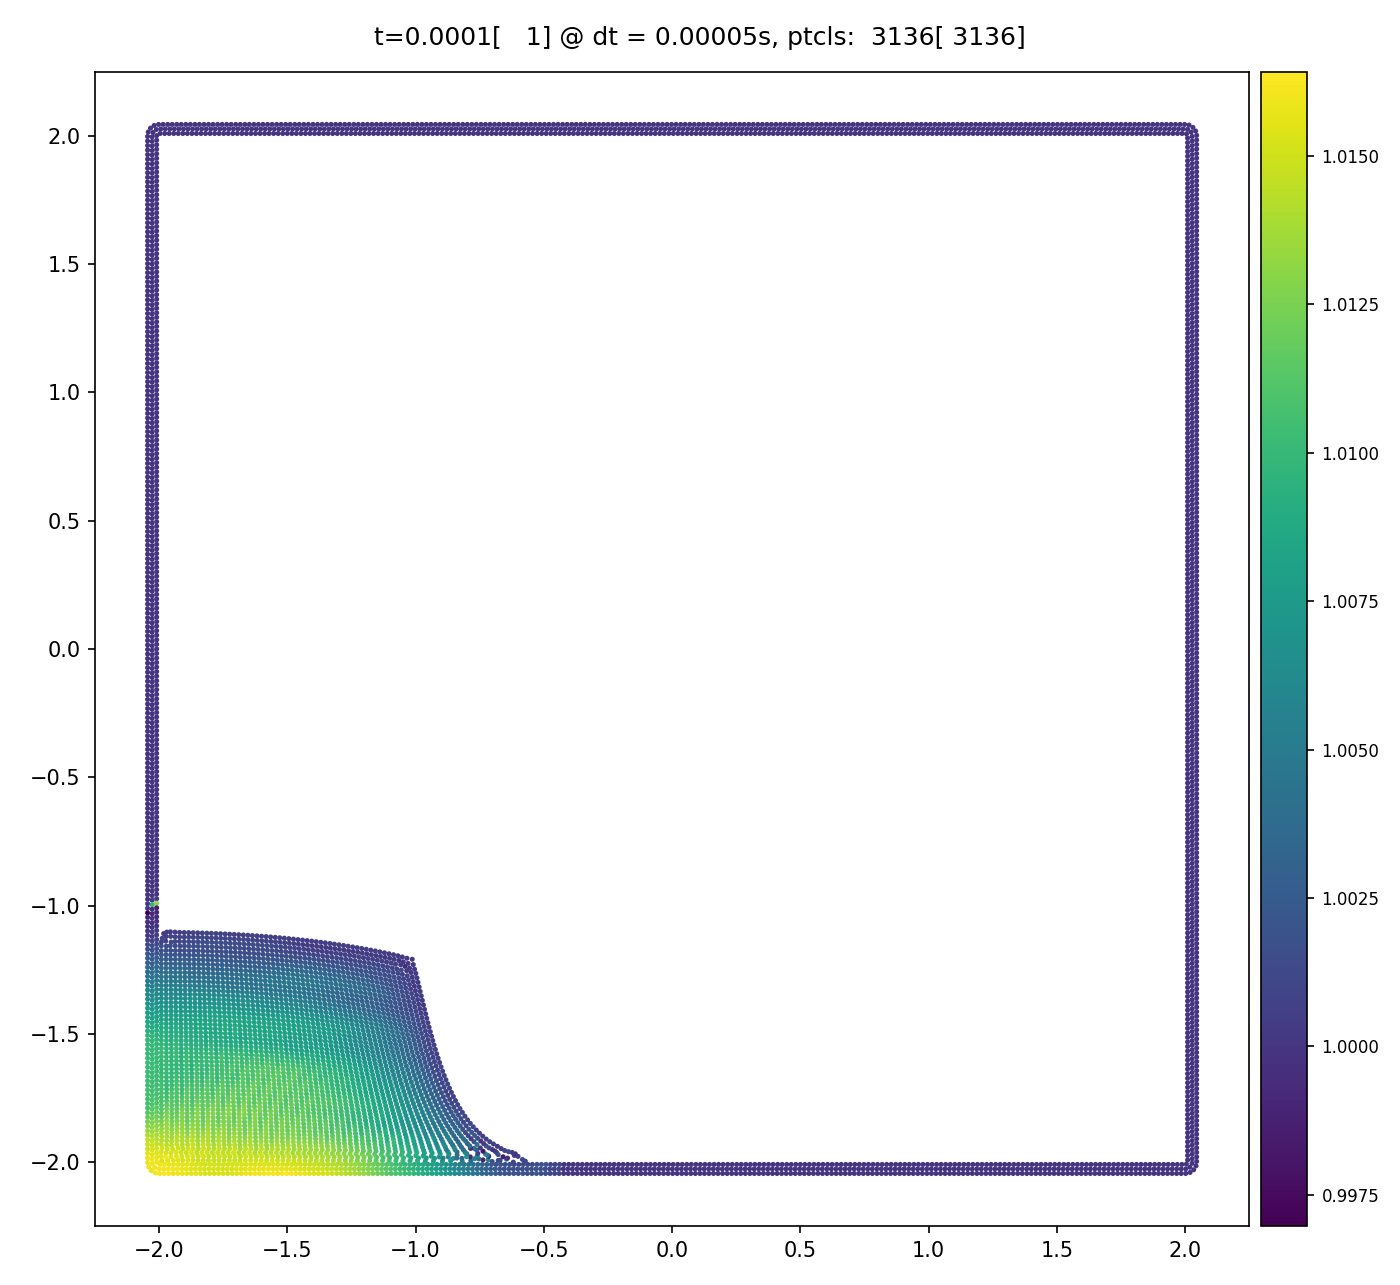

In [23]:
# parsedConfig = tomli.loads(tomlConfig)
# sphSimulation = torchSPH(parsedConfig)
# sphSimulation.initializeSimulation()
# sphSimulation.timestep()

fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)

state = sphSimulation.simulationState


positions = state['fluidPosition'].detach().cpu().numpy()
# data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# data2 = state['akinciBoundary']['boundaryDensity'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()
# data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()

positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.pressure.detach().cpu().numpy()
# data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()

data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

# data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
# data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

positions = np.vstack((positions, positions2))
data = np.hstack((data, data2))

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# quiverData = state['fluidUpdate'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# quiverData = state['lambdaGrad'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)


fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
if 'densityErrors' in state and not 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
if 'divergenceErrors' in state and not 'densityErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
if 'densityErrors' in state and 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

fig.tight_layout()



In [24]:
for i in tqdm(range(4096)):
    sphSimulation.timestep()
    if i  % 100 == 0:
        positions = state['fluidPosition'].detach().cpu().numpy()

        positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
        
        data = state['fluidDensity'].detach().cpu().numpy()
        data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()
        
#         data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
#         data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
        
#         data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.pressure.detach().cpu().numpy()

        positions = np.vstack((positions, positions2))
        data = np.hstack((data, data2))

        sc.set_offsets(positions)
        sc.set_array(data)
        cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        fig.canvas.draw()
        fig.canvas.flush_events()

  0%|          | 0/4096 [00:00<?, ?it/s]

In [22]:
simulationState = sphSimulation.simulationState

In [53]:
debugPrint(sphSimulation.boundaryModule.restDensity)

sphSimulation.boundaryModule.restDensity [int] = 1000


In [55]:
# debugPrint(torch.max(radialDistances))

torch.max(radialDistances) [Tensor] = 0.9999891519546509


shepardNominator[bb[0]] [Tensor] = 0.02810741774737835
shepardDenominator[bb[0]] [Tensor] = 2.8107418984291144e-05
shepardDensity[bb[0]] [Tensor] = 999.9999389648438
volumeSum[bb[0]] [Tensor] = 2.8107418984291144e-05
volumeGradSum[bb[0]] [Tensor] = tensor([ 0.0031, -0.0065])
b[bb[0]] [Tensor] = tensor([ 0.0281,  3.1383, -6.4878])
shepardNominator[bb[0]] [Tensor] = 0.02810741774737835
gradientSum[bb[0]] [Tensor] = tensor([ 3.1383, -6.4878])
xij [Tensor] = tensor([[ 0.0708, -0.1133],
        [ 0.0531, -0.1133],
        [ 0.0885, -0.0956],
        ...,
        [-0.1013,  0.0177],
        [-0.1190,  0.0177],
        [-0.1013,  0.0885]])
A_g[bb[0]] [Tensor] = tensor([[ 2.8107e-05,  1.5172e-06, -3.1833e-06],
        [ 3.1383e-03,  1.7348e-04, -3.5543e-04],
        [-6.4878e-03, -3.5543e-04,  7.3478e-04]])
A_g_inv[bb[0]] [Tensor] = tensor([[ 7.0569e+02, -3.4935e+04, -1.7048e+04],
        [-1.3015e+04,  6.4588e+05,  3.1237e+05],
        [-8.0172e+01,  3.9689e+03,  1.9367e+03]])
res[bb[0]] [Ten

<IPython.core.display.Javascript object>


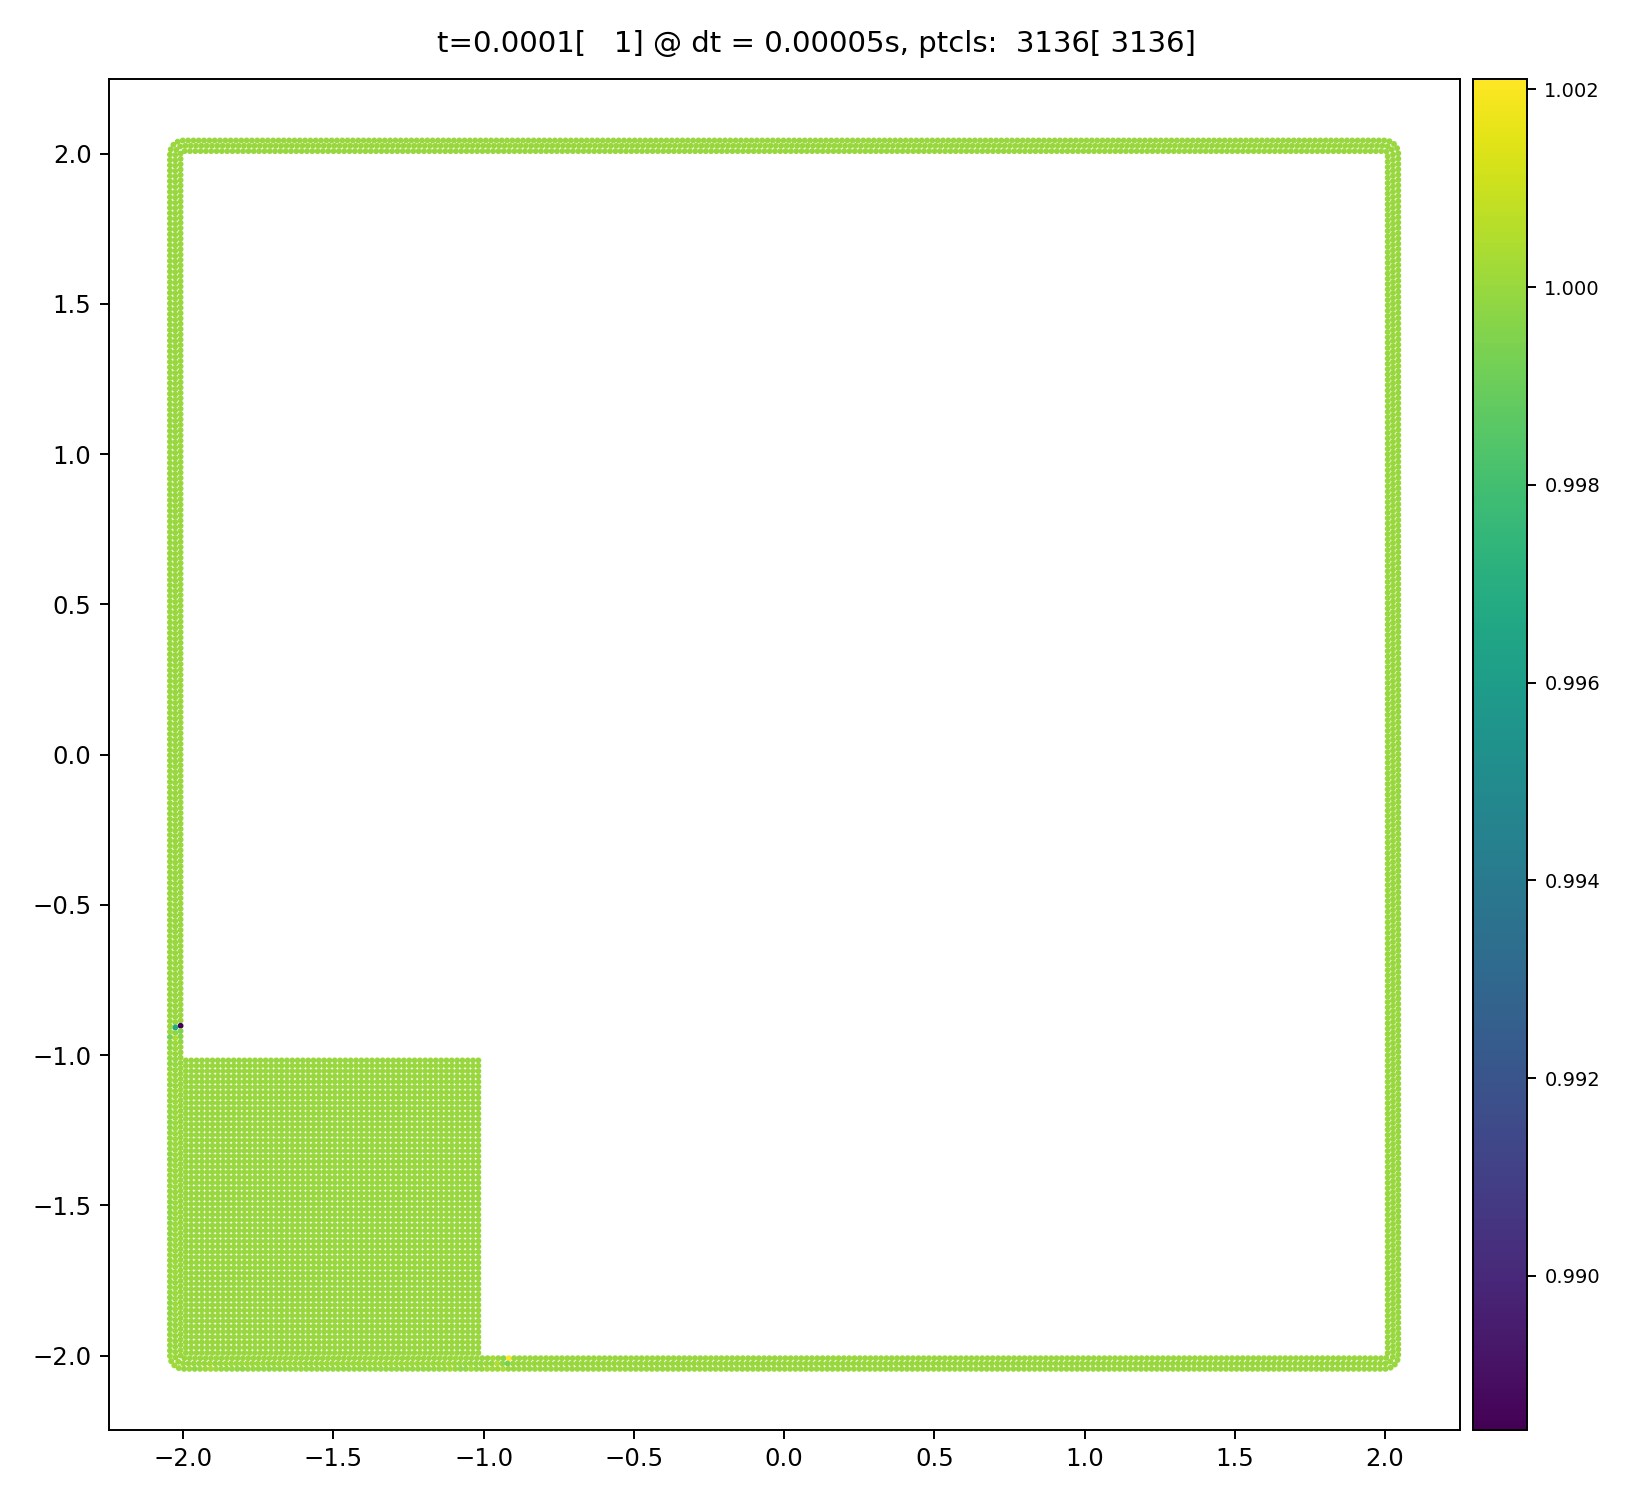

In [57]:
# parsedConfig = tomli.loads(tomlConfig)
# sphSimulation = torchSPH(parsedConfig)
# sphSimulation.initializeSimulation()
# sphSimulation.timestep()

fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)

state = sphSimulation.simulationState


positions = state['fluidPosition'].detach().cpu().numpy()
# data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
# data2 = state['akinciBoundary']['boundaryDensity'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()
data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()

positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
data2 = sphSimulation.boundaryModule.pressure.detach().cpu().numpy()
data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()

data2 = density.detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

positions = np.vstack((positions, positions2))
data = np.hstack((data, data2))

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

# quiverData = state['fluidUpdate'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# quiverData = state['lambdaGrad'].detach().cpu().numpy()
# qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
#                       scale_units='xy', scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)


fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
if 'densityErrors' in state and not 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
if 'divergenceErrors' in state and not 'densityErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
if 'densityErrors' in state and 'divergenceErrors' in state:
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

fig.tight_layout()



In [ ]:
fig, plots = plotSimulation(sphSimulation.simulationState, sphSimulation)

In [113]:
for i in tqdm(range(1024)):
    sphSimulation.timestep()
    if i  % 100 == 0:
        updatePlot(fig, plots, sphSimulation.simulationState, sphSimulation)

  0%|          | 0/1024 [00:00<?, ?it/s]

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


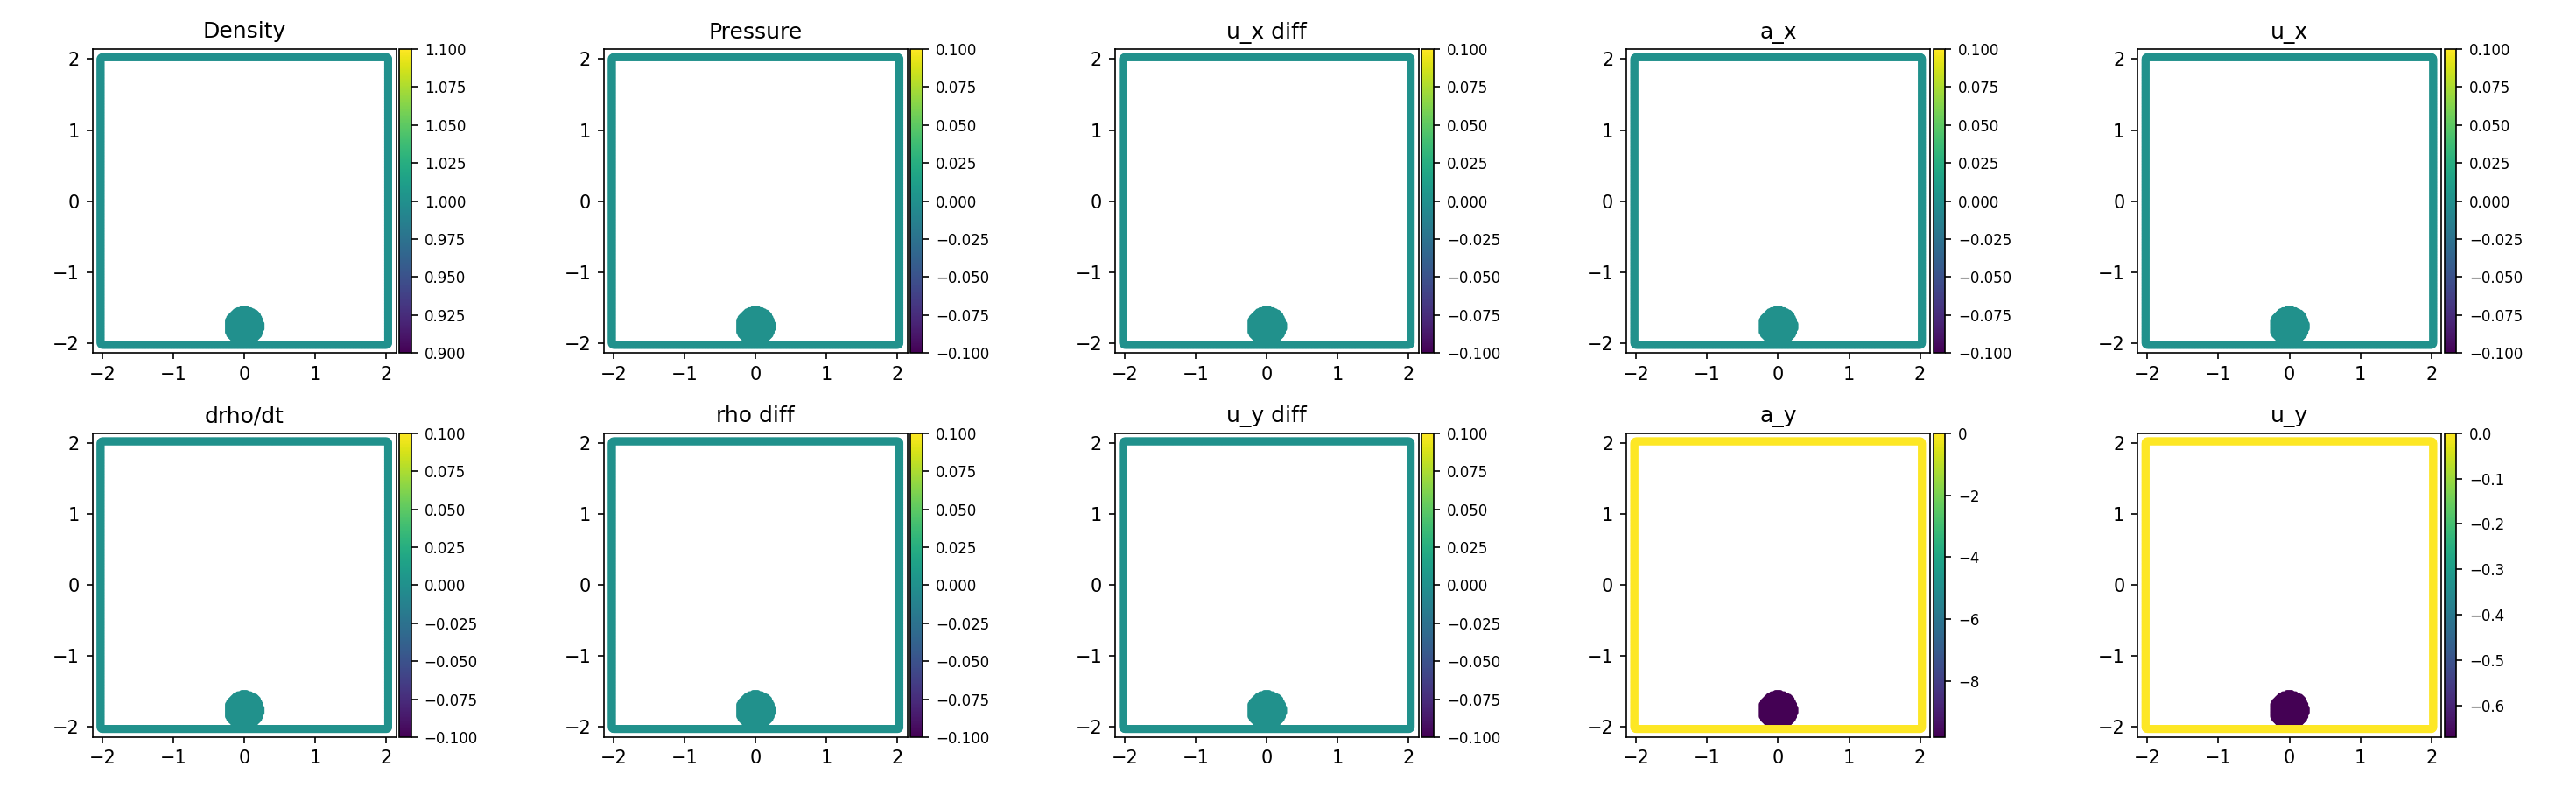

In [88]:
fig, axis = plt.subplots(2,5, figsize=(18 *  1.09, 6), squeeze = False)
for axx in axis:
    for ax in axx:
        ax.axis('equal')
        ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
        ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
#         ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
#         ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

def scatter(axis, fluidPositions, fluidData, boundaryPositions = None, boundaryData = None, label = None):
    positions = fluidPositions.detach().cpu().numpy()
    M = fluidData.detach().cpu().numpy()
    
    if boundaryPositions is not None and boundaryData is not None:
        bPositions = boundaryPositions.detach().cpu().numpy()
        bM = boundaryData.detach().cpu().numpy()
        
        positions = np.vstack((positions, bPositions))
        M = np.hstack((M, bM))
    elif boundaryPositions is not None and boundaryData is None:
        bPositions = boundaryPositions.detach().cpu().numpy()
        bM = torch.zeros(bPositions.shape[0]).detach().cpu().numpy()
        
        positions = np.vstack((positions, bPositions))
        M = np.hstack((M, bM))  
        
        
    sc = axis.scatter(positions[:,0], positions[:,1], c = M, s = 4)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    if label is not None:
        axis.set_title(label)
    return sc, cbar
    
scatter(axis[0,0], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = simulationState['fluidDensity'], boundaryData = simulation.boundaryModule.boundaryDensity, label = 'Density')
scatter(axis[1,0], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = sphSimulation.deltaSPH.dpdt, boundaryData = None, label = 'drho/dt')

scatter(axis[0,1], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = sphSimulation.deltaSPH.pressure, boundaryData = None, label = 'Pressure')
scatter(axis[1,1], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = sphSimulation.deltaSPH.densityDiffusion, boundaryData = None, label = 'rho diff')

scatter(axis[0,2], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = sphSimulation.deltaSPH.velocityDiffusion[:,0], boundaryData = None, label = 'u_x diff')
scatter(axis[1,2], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = sphSimulation.deltaSPH.velocityDiffusion[:,1], boundaryData = None, label = 'u_y diff')

scatter(axis[0,3], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = simulationState['fluidAcceleration'][:,0], boundaryData = None, label = 'a_x')
scatter(axis[1,3], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = simulationState['fluidAcceleration'][:,1], boundaryData = None, label = 'a_y')

scatter(axis[0,4], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = simulationState['fluidVelocity'][:,0], boundaryData = None, label = 'u_x')
scatter(axis[1,4], fluidPositions = simulationState['fluidPosition'], boundaryPositions = simulation.boundaryModule.boundaryPositions, fluidData = simulationState['fluidVelocity'][:,1], boundaryData = None, label = 'u_y')
    
fig.tight_layout()

In [ ]:
fig, axis = plt.subplots(2,2, figsize=(9 *  1.09, 9), squeeze = False)
for axx in axis:
    for ax in axx:
        ax.axis('equal')
        ax.set_xlim(sphSimulation.config['domain']['virtualMin'][0], sphSimulation.config['domain']['virtualMax'][0])
        ax.set_ylim(sphSimulation.config['domain']['virtualMin'][1], sphSimulation.config['domain']['virtualMax'][1])
#         ax.axvline(sphSimulation.config['domain']['min'][0], ls= '--', c = 'black')
#         ax.axvline(sphSimulation.config['domain']['max'][0], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['min'][1], ls= '--', c = 'black')
#         ax.axhline(sphSimulation.config['domain']['max'][1], ls= '--', c = 'black')

positions = simulationState['fluidPosition']
M = deltaModule.fluidL

bPositions = simulation.boundaryModule.boundaryPositions
bM = simulation.boundaryModule.boundaryL
# bPositions = simulation.boundaryModule.ghostParticlePosition
# bM = boundaryNormalizationMatrix

positions = torch.vstack((positions, bPositions)).detach().cpu().numpy()
M = torch.vstack((M, bM)).detach().cpu().numpy()

# positions = bPositions.detach().cpu().numpy()
# M = bM.detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = M[:,0,0], s = 4)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 
sc = axis[0,1].scatter(positions[:,0], positions[:,1], c = M[:,0,1], s = 4)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 
sc = axis[1,0].scatter(positions[:,0], positions[:,1], c = M[:,1,0], s = 4)
ax1_divider = make_axes_locatable(axis[1,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 
sc = axis[1,1].scatter(positions[:,0], positions[:,1], c = M[:,1,1], s = 4)
ax1_divider = make_axes_locatable(axis[1,1])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()

In [ ]:
for i in tqdm(range(1024)):
    sphSimulation.timestep()

    
#     positions2 = state['akinciBoundary']['positions'].detach().cpu().numpy()
    # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
#     data2 = state['akinciBoundary']['boundaryDensity'].detach().cpu().numpy()


    positions = state['fluidPosition'].detach().cpu().numpy()
    # data = torch.linalg.norm(state['fluidUpdate'].detach(),axis=1).cpu().numpy()
#     data2 = state['akinciBoundary']['boundaryDensity'].detach().cpu().numpy()
    data = state['fluidDensity'].detach().cpu().numpy()
#     data2 = state['akinciBoundary']['boundaryPressure'].detach().cpu().numpy()
#     data = state['fluidPressure'].detach().cpu().numpy()


#     positions = np.vstack((positions, positions2))
#     data = np.hstack((data, data2))

    positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
    data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy()

    positions = np.vstack((positions, positions2))
    data = np.hstack((data, data2))


    sc.set_offsets(positions)
    sc.set_array(data)
    cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
    if 'densityErrors' in state and not 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
    if 'divergenceErrors' in state and not 'densityErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
    if 'densityErrors' in state and 'divergenceErrors' in state:
        fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))


#     if torch.any(torch.isnan(state['boundaryDensity'])) or torch.any(torch.isnan(state['boundaryGradient'])):
#         raise Exception('Simulation borked')

In [26]:


with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.timestep()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          full Timestep         1.69%       1.165ms        99.92%      68.985ms      68.985ms         -88 b        -268 b             1  
                                4 - density  evaluation         0.13%      90.000us        37.32%      25.764ms      25.764ms          -4 b    -780.51 Kb             1  
                      boundaryCondition[mDBC] - density         2.20%       1.522ms        37.13%      25.634ms      25.634ms     757.29 Kb      -4.56

In [669]:


with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            timestep()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       full Timestep         0.74%     487.000us        99.91%      65.399ms      65.399ms       6.55 Mb      -2.73 Mb             1  
                            deltaSPH - compute terms         0.48%     311.000us        76.08%      49.798ms      49.798ms       1.68 Mb        -268 b             1  
                                         aten::index        23.66%      15.485ms        26.12%      17.096ms     427.400us      30.91 Mb      -4.32 Mb            40 